# Prediction du salaire basés sur les offres d'emplois

Les données proviennent d'une ancienne compétition postée par Adzuna afin de prédire des salaires pour des jobs en Grande-Bretagne en se basant sur quelques attributs. La base de données contient un grand nombre de lignes représentant des offres d'emplois individuelles, ainsi qu'une série de champs relatifs à chaque offre.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import spacy
import nltk
import warnings
warnings.filterwarnings("ignore")
import pandas.util.testing as tm

/home/quentin/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Chargement des données

In [2]:
df = pd.read_csv('../Dataset_directory/salary_data.csv')
df.shape

(244768, 12)

# Examiner la structure des données

Examinons les trois premières lignes à l'aider de la méthode `head()` du DataFrame :

In [3]:
df.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk


Chaque ligne représente une offre d'emploi. Il y a __12 variables__ : *Id*, *Title*, *FullDescription*, *LocationRaw*, *LocationNormalized*, 
*ContractType*, *ContractTime*, *Company*, *Category*, *SalaryRaw*, *SalaryNormalized* et *SourceName*.

Je sais par avance que je ne vais pas exploiter les variables *Id*, *LocationRaw*, et *SalaryRaw*, je les supprime donc du jeu de données :

In [4]:
df.drop(['Id','LocationRaw','SalaryRaw'], inplace=True, axis=1)

La méthode `info()` permet d'obtenir une description des données, en particulier le nombre total de lignes, le type de chaque variable et le nombre de valeurs non nulles : 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Title               244767 non-null  object
 1   FullDescription     244768 non-null  object
 2   LocationNormalized  244768 non-null  object
 3   ContractType        65442 non-null   object
 4   ContractTime        180863 non-null  object
 5   Company             212338 non-null  object
 6   Category            244768 non-null  object
 7   SalaryNormalized    244768 non-null  int64 
 8   SourceName          244767 non-null  object
dtypes: int64(1), object(8)
memory usage: 16.8+ MB


Il est possible de changer le type des variables catégorielles de type `object` en type `category`, ainsi que les variables textuelles de type `object` en type `string` : ces nouveaux formats seront non seulement plus adaptés, mais permettront également d'utiliser moins de mémoire.  

In [6]:
# Conversion des variables textuelles 
#df["Title"] = df["Title"].astype("string")
#df["FullDescription"] = df["FullDescription"].astype("string")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Title               244767 non-null  object
 1   FullDescription     244768 non-null  object
 2   LocationNormalized  244768 non-null  object
 3   ContractType        65442 non-null   object
 4   ContractTime        180863 non-null  object
 5   Company             212338 non-null  object
 6   Category            244768 non-null  object
 7   SalaryNormalized    244768 non-null  int64 
 8   SourceName          244767 non-null  object
dtypes: int64(1), object(8)
memory usage: 16.8+ MB


Il y a 244 768 lines dans ce tableau. On remarque que la variable `ContractType` ne contient que 65 442 valeurs valides ("not-null") :

In [8]:
print("Seul {:.0%} des valeurs de la variable ContractType sont valides.".format(65_442/244_768))

Seul 27% des valeurs de la variable ContractType sont valides.


Je décide donc de la supprimer afin d'éviter d'introduire trop de bruits dans les données, considérant par ailleurs que la variable `ContractTime` contient suffisamment d'information : 

In [9]:
df.drop('ContractType', inplace=True, axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Title               244767 non-null  object
 1   FullDescription     244768 non-null  object
 2   LocationNormalized  244768 non-null  object
 3   ContractTime        180863 non-null  object
 4   Company             212338 non-null  object
 5   Category            244768 non-null  object
 6   SalaryNormalized    244768 non-null  int64 
 7   SourceName          244767 non-null  object
dtypes: int64(1), object(7)
memory usage: 14.9+ MB


In [11]:
def missing_values_table(df) :
    '''
        Fonction permettant d'obtenir des informations concernant les valeurs manquantes d'un jeu de données. 
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending = False).round(1)
        
    return mis_val_table_ren_columns

Nous pouvons voir qu'il y a des valeurs manquantes dans __les variables catégorielles__ `ContractTime`,`Company` et `SourceName`. Pour les deux premières, comme leur nombre est relativement élevé, nous préfèrerons les considérer comme __une nouvelle catégorie à part entière__. Pour la variable `SourceName`, comme il n'y en a qu'une seule, nous remplacerons cette valeur manquante par la valeur la plus fréquente du jeu d'entraînement avec la classe `SimpleImputer()`.

In [12]:
for f in ["ContractTime","Company"] :
    df[f].replace({np.nan:"Other"}, inplace = True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Title               244767 non-null  object
 1   FullDescription     244768 non-null  object
 2   LocationNormalized  244768 non-null  object
 3   ContractTime        244768 non-null  object
 4   Company             244768 non-null  object
 5   Category            244768 non-null  object
 6   SalaryNormalized    244768 non-null  int64 
 7   SourceName          244767 non-null  object
dtypes: int64(1), object(7)
memory usage: 14.9+ MB


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Title               244767 non-null  object
 1   FullDescription     244768 non-null  object
 2   LocationNormalized  244768 non-null  object
 3   ContractTime        244768 non-null  object
 4   Company             244768 non-null  object
 5   Category            244768 non-null  object
 6   SalaryNormalized    244768 non-null  int64 
 7   SourceName          244767 non-null  object
dtypes: int64(1), object(7)
memory usage: 14.9+ MB


Nous avons donc __7 variables explicatives__ et __1 variable d'intérêt__.
Les 7 variables explicatives sont *Title*, *FullDescription*, *LocationNormalized*, *ContractTime*, *Company*, *Category* et *SourceName*. Les deux premières sont __textuelles__, les autres sont __catégorielles__. La variable d'intérêt *SalaryNormalized* est un entier naturel que nous chercherons à prédire.

Commençons par examiner le nombre de modalités pour chacune des variables catégorielles :

In [15]:
df[["LocationNormalized","ContractTime","Company","Category","SourceName"]].head(3)

,LocationNormalized,ContractTime,Company,Category,SourceName
0,Dorking,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk
1,Glasgow,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk
2,Hampshire,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk


In [16]:
list_cat_var = ["LocationNormalized","ContractTime","Company","Category","SourceName"]
for f in list_cat_var :
    print("- {}: {} catégories différentes.\n{}".format(f, df[f].nunique(), "-"*50))

- LocationNormalized: 2732 catégories différentes.
--------------------------------------------------
- ContractTime: 3 catégories différentes.
--------------------------------------------------
- Company: 20813 catégories différentes.
--------------------------------------------------
- Category: 29 catégories différentes.
--------------------------------------------------
- SourceName: 167 catégories différentes.
--------------------------------------------------


In [17]:
df["ContractTime"].value_counts(normalize=True, dropna=False)

permanent    0.619039
Other        0.261084
contract     0.119877
Name: ContractTime, dtype: float64

Concernant ces variables catégorielles ayant beaucoup de modalités, il serait intéressant d'en savoir plus sur la __représentatitivé des catégories au sein de la variable.__ Pour cela, je vais créer une fonction `get_cdf()` permettant de visualiser la fonction de répartition empirique associé à cette variable.  

In [18]:
def get_cdf(variable):
    values = df[variable].value_counts(normalize=True).values
    y = np.cumsum(values) ; x = np.arange(0,len(y))
    plt.ylabel("Fonction de répartion", fontsize=15) ; plt.xlabel(variable, fontsize=15)
    plt.plot(x,y) ; plt.show()
    q_25 = np.argmax(y > .25) + 1 ; q_50 = np.argmax(y > 0.50) + 1 ; q_75 = np.argmax(y > .75) + 1
    print("25%: {}\n50%: {}\n75%: {}".format(q_25,q_50,q_75))

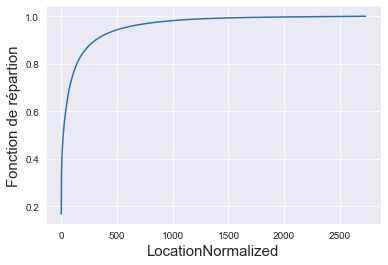

25%: 2
50%: 19
75%: 103


In [19]:
get_cdf("LocationNormalized")

- Les __2 villes__ présentant le plus d'annonces d'emploi représentent __25% du total des annonces d'emploi.__

- Les __19 villes__ présentant le plus d'annonces d'emploi représentent __50% du total des annonces d'emploi.__

- Les __103 villes__ présentant le plus d'annonces d'emploi représentent __75% du total des annonces d'emploi.__

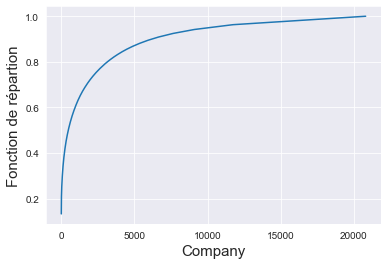

25%: 32
50%: 479
75%: 2338


In [20]:
get_cdf("Company")

- Les __129 entreprises__ présentant le plus d'annonces d'emploi représentent __25% du total des annonces d'emploi.__

- Les __759 entreprises__ présentant le plus d'annonces d'emploi représentent __50% du total des annonces d'emploi.__

- Les __2849 entreprises__ présentant le plus d'annonces d'emploi représentent __75% du total des annonces d'emploi.__

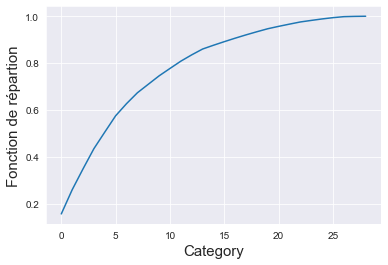

25%: 2
50%: 5
75%: 11


In [21]:
get_cdf("Category")

- Les __2 catégories d'emplois__ les plus représentées représentent __25% du total des annonces d'emploi.__

- Les __5 catégories d'emplois__ les plus représentées représentent __50% du total des annonces d'emploi.__

- Les __11 catégories d'emplois__ les plus représentées représentent __75% du total des annonces d'emploi.__

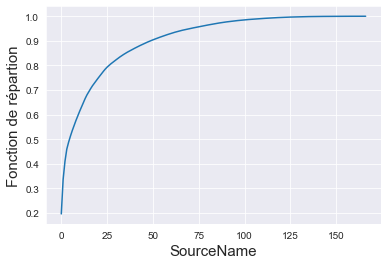

25%: 2
50%: 6
75%: 22


In [22]:
get_cdf("SourceName")

- Les __2 sites__ présentant le plus d'annonces d'emploi représentent __25% du total des annonces d'emploi.__

- Les __6 sites__ présentant le plus d'annonces d'emploi représentent __50% du total des annonces d'emploi.__

- Les __22 sites__ présentant le plus d'annonces d'emploi représentent __75% du total des annonces d'emploi.__

Examinons maintenant les __variables textuelles :__ 

In [23]:
df[["Title","FullDescription"]].head()

,Title,FullDescription
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do..."


In [24]:
np.random.seed(123)
for i in np.random.randint(1,54321,3) :
    print("Title:\n{}\n".format(df.loc[i,"Title"]))
    print("Full Description:\n{}".format(df.loc[i,"FullDescription"]))
    print("-"*100)

Title:
Quantity Surveyor

Full Description:
Time 4 Recruitment Solutions… Specialise in supplying permanent and contract labour to the construction, mechanical and electrical, catering and industrial markets. Wanted An experienced Quantity Surveyor or an established contractor within the Civil Engineering and Power Generation sectors. The Company… My client is a World leader in the UK ’s **** billion development of wind farms and has seen significant recent investment in its facilities, people, and research and development. From its manufacturing facility through to its worldclass Energy Service Training Centre and from pioneering technologies to skills development; they are ready for continued growth. The Job… They are looking to recruit an experienced Surveyor to work on 2 Wind Farm projects in the Swansea area of South Wales . You will spend **** days on one project and then 2 days on the other project. You will have experience of similar work or have worked on Civil Engineering pro

Examinons notre variable d'intérêt `SalaryNormalized` : 

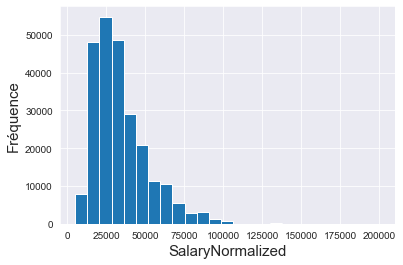

       SalaryNormalized
count     244768.000000
mean       34122.577576
std        17640.543124
min         5000.000000
25%        21500.000000
50%        30000.000000
75%        42500.000000
max       200000.000000


In [25]:
plt.hist(df["SalaryNormalized"],bins=25)
plt.xlabel("SalaryNormalized",fontsize=15)
plt.ylabel("Fréquence",fontsize=15)
plt.show()
print(df.describe())

* Le salaire normalisé moyen est de 34 123 
* Le salaire minimum est de 5 000
* 25% (75%) des salaires sont inférieurs (supérieurs) à 21 500
* 50% des salaires sont inférieurs à 30 000
* 75% (25%) des salaires sont inférieurs (supérieurs) à 42 500
* Le salaire maximum est de 200 000

__N.B__ Les salaires sont sans doute exprimés en livre sterling.

Examinons la relation entre les variables catégorielles ayant relativement peu de modalités (`Category` avec 29 modalités, `ContractTime` avec 2 modalités) et la variable d'intérêt `SalaryNormalized` :

In [26]:
df.groupby('ContractTime')['SalaryNormalized'].agg(['count','mean','median','min','max','std']).transpose()

ContractTime,Other,contract,permanent
count,63905.000000,29342.000000,151521.000000
mean,30189.156107,36274.116079,35364.879673
median,25000.000000,30000.000000,32500.000000
min,5000.000000,5000.000000,5000.000000
max,200000.000000,192000.000000,200000.000000
std,17593.270422,22621.070725,16251.148748


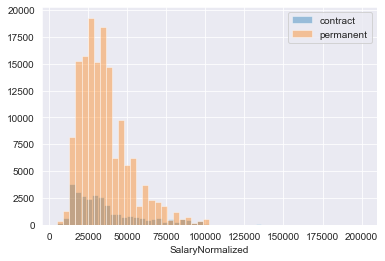

In [27]:
sns.distplot(df[df["ContractTime"] == "contract"]["SalaryNormalized"], label="contract", kde=False)
sns.distplot(df[df["ContractTime"] == "permanent"]["SalaryNormalized"], label="permanent", kde=False)
plt.legend()
plt.show()

Hormis le fait qu'il y ait __bien plus d'annonces de types permanentes que de types contractuelles__ (151 521 permanents contre 29 342 contractuelles), il n'y a pas de différences significatives entre ces deux distributions.

Affichons maintenant __le salaire médian par catégorie d'emploi :__

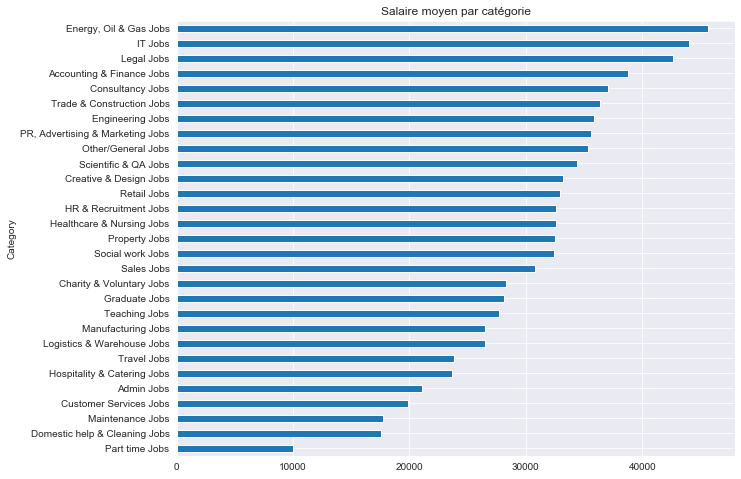

In [28]:
df.groupby('Category')['SalaryNormalized'].mean().sort_values(ascending=True).plot(
kind='barh',figsize=(10,8),title="Salaire moyen par catégorie");

Les secteurs de l'énergie, des technologies de l'information, du droit, des finances et du consultanat sont les secteurs proposant, en moyenne, les plus hauts salaires. A l'inverse, les temps partiels, les jobs d'aide à domicile et les travaux de maintenance sont les secteurs qui proposent, en moyenne, les salaires les plus bas.

# Créer un jeu de test 

Supposons que __la catégorie d'emploi est une variable importante pour prédire le salaire.__ Je veux m'assurer que le jeu de test est représentatif des différentes catégories d'emplois figurant dans le jeu de données complet.

Je vais effectuer un échantillonnage stratifié basé sur __les catégories d'emploi__.

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(df, df["Category"]) :
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

Je peux vérifier que les proportions soient identiques dans chacune des strates : 

In [30]:
pd.DataFrame({'Total set': df["Category"].value_counts(normalize=True),
              'Train set': strat_train_set["Category"].value_counts(normalize=True),
              'Test set': strat_test_set["Category"].value_counts(normalize=True)})

,Total set,Train set,Test set
IT Jobs,0.157222,0.157222,0.157222
Engineering Jobs,0.102848,0.102850,0.102845
Accounting & Finance Jobs,0.089252,0.089251,0.089254
Healthcare & Nursing Jobs,0.086106,0.086105,0.086108
Sales Jobs,0.070565,0.070563,0.070570
Other/General Jobs,0.069678,0.069676,0.069684
Teaching Jobs,0.051628,0.051629,0.051627
Hospitality & Catering Jobs,0.046375,0.046376,0.046370
"PR, Advertising & Marketing Jobs",0.036173,0.036174,0.036170
Trade & Construction Jobs,0.036104,0.036104,0.036102


In [31]:
strat_train_set.head(3)

,Title,FullDescription,LocationNormalized,ContractTime,Company,Category,SalaryNormalized,SourceName
184761,Assistant Managers (ready for the next step),Assistant Managers (ready for the next step) S...,London,Other,Leisure Jobs,Hospitality & Catering Jobs,25000,jobs.catererandhotelkeeper.com
88459,Global Development Manager,The Global Development Manager role will lead ...,UK,Other,Springboard Ltd,Other/General Jobs,62499,theladders.co.uk
9698,Resourcing Consultant,"Based just outside Bath, this job as a Resourc...",Bath,permanent,Other,Manufacturing Jobs,35000,hays.co.uk


In [32]:
X_train = strat_train_set.drop("SalaryNormalized", axis=1)
X_test = strat_test_set.drop("SalaryNormalized", axis=1)
y_train = strat_train_set["SalaryNormalized"]
y_test = strat_test_set["SalaryNormalized"]

In [33]:
X_train.head(3)

,Title,FullDescription,LocationNormalized,ContractTime,Company,Category,SourceName
184761,Assistant Managers (ready for the next step),Assistant Managers (ready for the next step) S...,London,Other,Leisure Jobs,Hospitality & Catering Jobs,jobs.catererandhotelkeeper.com
88459,Global Development Manager,The Global Development Manager role will lead ...,UK,Other,Springboard Ltd,Other/General Jobs,theladders.co.uk
9698,Resourcing Consultant,"Based just outside Bath, this job as a Resourc...",Bath,permanent,Other,Manufacturing Jobs,hays.co.uk


# Encodage en fréquence

Cette technique consiste à __transformer les modalités d'une variable qualitative en valeurs comprise entre 0 et 1__ correspondant à leurs __fréquences relatives__. Nous pouvons voir ces fréquences comme étant la probabilité de rencontrer cette modalité dans notre jeu de données.
Cela permet par ailleurs d'éviter l'explosion du nombres de variables suite à un one-hot encoding. 

In [34]:
def get_freq_encoding(dataset, train_file):
    
    '''
       Fonction permettant d'appliquer l'encodage en fréquence sur le jeu d'entraînement.
       Les nouvelles modalités calculées sur le jeu d'entraînement seront ensuite appliquées au jeu de test.
    '''
    
    for c in ["LocationNormalized","ContractTime","Company","Category","SourceName"] :
        data = train_file.groupby([c]).size()/len(train_file)
        dataset[c] = dataset[c].map(data)
    return dataset

In [35]:
X_test = get_freq_encoding(dataset = X_test, train_file = X_train)
X_train = get_freq_encoding(dataset = X_train, train_file = X_train)

In [36]:
X_train.head(3)

,Title,FullDescription,LocationNormalized,ContractTime,Company,Category,SourceName
184761,Assistant Managers (ready for the next step),Assistant Managers (ready for the next step) S...,0.124742,0.261438,0.000391,0.046376,0.014982
88459,Global Development Manager,The Global Development Manager role will lead ...,0.167471,0.261438,0.000012,0.069676,0.009303
9698,Resourcing Consultant,"Based just outside Bath, this job as a Resourc...",0.001360,0.618337,0.132231,0.015379,0.012980


In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171337 entries, 184761 to 157239
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Title               171337 non-null  object 
 1   FullDescription     171337 non-null  object 
 2   LocationNormalized  171337 non-null  float64
 3   ContractTime        171337 non-null  float64
 4   Company             171337 non-null  float64
 5   Category            171337 non-null  float64
 6   SourceName          171336 non-null  float64
dtypes: float64(5), object(2)
memory usage: 10.5+ MB


# Traitement des valeurs numériques manquantes

In [38]:
X_train_num = X_train.select_dtypes(include=float)
X_test_num = X_test.select_dtypes(include=float)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")

# Fit sur le jeu d'entraînement 
imputer.fit(X_train_num)

# Transform sur le jeu d'entraînement et sur le jeu de test 
X_train_num = pd.DataFrame(imputer.transform(X_train_num), columns = X_train_num.columns)
X_test_num = pd.DataFrame(imputer.transform(X_test_num), columns = X_test_num.columns)

# Réinitialisation de l'index des vecteurs y_train et y_test  
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [39]:
X_train_num.head(3)

,LocationNormalized,ContractTime,Company,Category,SourceName
0,0.124742,0.261438,0.000391,0.046376,0.014982
1,0.167471,0.261438,0.000012,0.069676,0.009303
2,0.001360,0.618337,0.132231,0.015379,0.012980


# Variables textuelles

In [40]:
X_train_text = X_train[["Title","FullDescription"]]
X_test_text = X_test[["Title","FullDescription"]]

In [41]:
X_train_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171337 entries, 184761 to 157239
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Title            171337 non-null  object
 1   FullDescription  171337 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


In [42]:
X_test_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73431 entries, 153021 to 15141
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            73430 non-null  object
 1   FullDescription  73431 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Title

In [44]:
Title_train = X_train_text["Title"].apply(lambda x: np.str_(x))
Title_test = X_test_text["Title"].apply(lambda x: np.str_(x))

# Train
tfidf_vect_train = TfidfVectorizer(max_features=200, stop_words="english", ngram_range=(1,2))

Title_train_tfidf = tfidf_vect_train.fit_transform(Title_train)
print("Title_train_tfidf.shape: {}\n".format(Title_train_tfidf.shape))

title_names_train = tfidf_vect_train.get_feature_names()
print("Title_train_tfidf 10 first features:\n", title_names_train[:10])

# Test
tfidf_vect_test = TfidfVectorizer(max_features=200, stop_words="english",
                                  ngram_range=(1,2),vocabulary=title_names_train)

Title_test_tfidf = tfidf_vect_test.fit_transform(Title_test)
print("\nTitle_test_tfidf.shape: {}\n".format(Title_test_tfidf.shape))

title_names_test = tfidf_vect_test.get_feature_names()
print("Title_test_tfidf 10 first features:\n", title_names_test[:10])

# Convert to dataframes

title_train = pd.DataFrame(Title_train_tfidf.toarray(), columns=title_names_train)
title_test = pd.DataFrame(Title_test_tfidf.toarray(), columns=title_names_test)

Title_train_tfidf.shape: (171337, 200)

Title_train_tfidf 10 first features:
 ['account', 'account manager', 'accountant', 'accounts', 'administrator', 'advisor', 'agency', 'analyst', 'application', 'architect']

Title_test_tfidf.shape: (73431, 200)

Title_test_tfidf 10 first features:
 ['account', 'account manager', 'accountant', 'accounts', 'administrator', 'advisor', 'agency', 'analyst', 'application', 'architect']


## Full Description

In [45]:
Description_train = X_train_text["FullDescription"].apply(lambda x: np.str_(x))
Description_test = X_test_text["FullDescription"].apply(lambda x: np.str_(x))

###### Train 

tfidf_vect_train = TfidfVectorizer(max_features=200, stop_words="english", ngram_range=(1,2))

Description_train_tfidf = tfidf_vect_train.fit_transform(Description_train)
print("\nDescription_train_tfidf.shape: {}\n".format(Description_train_tfidf.shape))

desc_names_train = tfidf_vect_train.get_feature_names()
print("Description_train_tfidf 10 first features:\n", desc_names_train[:10])

####### Test

tfidf_vect_test = TfidfVectorizer(max_features=200, stop_words="english",
                                  ngram_range=(1,2), vocabulary=desc_names_train)

Description_test_tfidf = tfidf_vect_test.fit_transform(Description_test)
print("\nDescription_test_tfidf.shape: {}\n".format(Description_test_tfidf.shape))

desc_names_test = tfidf_vect_test.get_feature_names()
print("Description_test_tfidf 10 first features:\n", desc_names_test[:10])

# Convert to dataframes

description_train = pd.DataFrame(Description_train_tfidf.toarray(), columns = desc_names_train)
description_test = pd.DataFrame(Description_test_tfidf.toarray(), columns = desc_names_test)


Description_train_tfidf.shape: (171337, 200)

Description_train_tfidf 10 first features:
 ['ability', 'able', 'account', 'agency', 'analysis', 'applicants', 'application', 'applications', 'apply', 'area']

Description_test_tfidf.shape: (73431, 200)

Description_test_tfidf 10 first features:
 ['ability', 'able', 'account', 'agency', 'analysis', 'applicants', 'application', 'applications', 'apply', 'area']


In [46]:
X_train = pd.concat([X_train_num, description_train, title_train], axis=1)
X_test = pd.concat([X_test_num, description_test, title_test], axis=1)

In [47]:
X_train.head(3)

,LocationNormalized,ContractTime,Company,Category,SourceName,ability,able,account,agency,analysis,...,time,trade,trainee,travel,uk,web,web developer,west,worker,year
0,0.124742,0.261438,0.000391,0.046376,0.014982,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.167471,0.261438,0.000012,0.069676,0.009303,0.088852,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001360,0.618337,0.132231,0.015379,0.012980,0.000000,0.111084,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
X_train.shape

(171337, 405)

# Prediction

In [49]:
from sklearn.model_selection import cross_validate
def cross_validate_results(model, X_train, y_train):
    scores = cross_validate(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error',
                            return_train_score=True)
    scores = pd.DataFrame(scores)
    results = scores.describe().transpose()
    return results

## Régression linéaire 

In [53]:
from sklearn.linear_model import LinearRegression
cross_validate_results(LinearRegression(), X_train, y_train)

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,3.578061,0.564904,2.791120,3.307022,3.654735,3.849206,4.288224
score_time,5.0,0.022874,0.010929,0.016765,0.017827,0.018207,0.019208,0.042362
test_score,5.0,-8872.998539,24.859488,-8895.094163,-8893.270572,-8884.350919,-8846.848048,-8845.428991
train_score,5.0,-8845.031419,11.345587,-8857.807281,-8854.141876,-8845.200507,-8837.568623,-8830.438806


## Random Forest Regressor

In [75]:
from sklearn.ensemble import RandomForestRegressor
cross_validate_results(RandomForestRegressor(random_state=123), X_train, y_train)

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1994.555574,119.846744,1933.445532,1933.597757,1948.103483,1949.113214,2208.517886
score_time,5.0,1.838732,0.017248,1.824986,1.825033,1.828532,1.856956,1.858155
test_score,5.0,-7105.024363,57.306352,-7163.368189,-7137.828023,-7130.304608,-7071.702169,-7021.918825
train_score,5.0,-2651.314893,3.389661,-2655.924837,-2652.497258,-2652.048787,-2648.910676,-2647.192905


Bien que le temps d'exécution de la régression linéaire soit bien plus rapide que celui du modèle purement non paramétrique `RandomForestRegressor()`, je décide de travailler avec ce dernier car il donne de bien meilleurs résultats (MAE à 7105 en moyenne sur le test).      

In [78]:
forest_reg = RandomForestRegressor(random_state=123)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

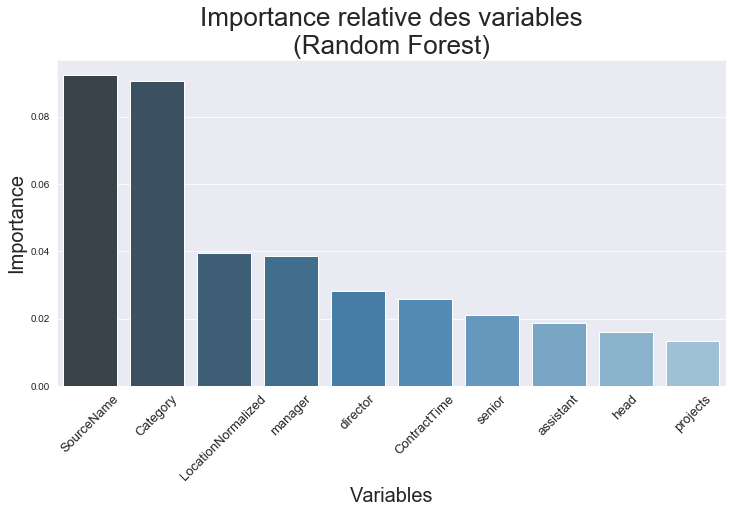

In [107]:
importances = forest_reg.feature_importances_
attributes = list(X_train)
a = sorted(zip(importances, attributes), reverse=True)[:10]
q = pd.DataFrame(a, columns = ["importances","variables"])
fig, ax = plt.subplots(figsize = (12,6)) 
sns.barplot(y="importances", x="variables", data=q, palette="Blues_d")
plt.xticks(rotation = 45,fontsize = 13)
plt.title("Importance relative des variables\n(Random Forest)", fontsize=26)
plt.xlabel('Variables',fontsize=20)
plt.ylabel("Importance",fontsize=20)
plt.show()

In [79]:
y_pred = forest_reg.predict(X_test)

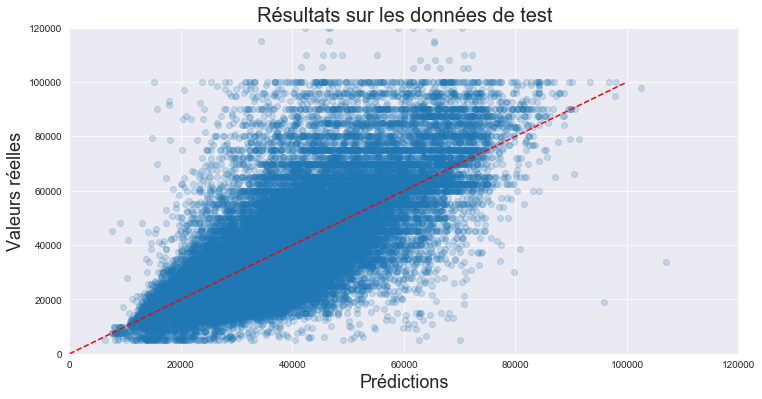

In [106]:
plt.figure(figsize=(12,6))
plt.scatter(x=y_pred, y=y_test, alpha=0.2)
plt.plot([0,100_000],[0,100_000], 'r--')
plt.xlim([0,120_100]) ; plt.ylim([0,120_000])
plt.title("Résultats sur les données de test", fontsize=20)
plt.xlabel("Prédictions",fontsize=18) ; plt.ylabel("Valeurs réelles", fontsize=18)
plt.show()

In [97]:
from sklearn.metrics import mean_absolute_error
print("Mean absolute error on test set: {}".format(mean_absolute_error(y_pred, y_test)))

Mean absolute error on test set: 6911.786662023594
